<a href="https://colab.research.google.com/github/vannarath-poeu/keyper/blob/main/max_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Codes to mount your google drive folder
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMU/Capstone/

Mounted at /content/drive
/content/drive/MyDrive/SMU/Capstone


In [96]:
#@title Install necessary packages
!pip install --quiet keybert[spacy] networkx[default] keyphrasetransformer

  Preparing metadata (setup.py) ... done


In [3]:
#@title Load and show example sections
import json

with open("example.json", "r") as f:
  example = json.load(f)

example["sections"]

['introduction',
 'implications of flow for learning',
 'flow and learning in a virtual world',
 'play and learning',
 'enhancing virtual learning through telepresence',
 'the hoffman and novak conceptual model',
 'participants',
 'treatment',
 'h',
 'hypotheses one and two',
 'hypothesis three',
 'discussion',
 'conclusion',
 'title',
 'abstract']

In [ ]:
sum([len(section_text) for section_text in example["sec_text"]])

7654

In [ ]:
[k for k in example]

['paper_id',
 'sections',
 'sec_text',
 'extractive_keyphrases',
 'abstractive_keyphrases']

In [4]:
#@title Show extractive and abstractive keywords
print("Extractive: ", example["extractive_keyphrases"])
print("Abstractive: ", example["abstractive_keyphrases"])

Extractive:  ['gaming', 'online learning', 'telepresence', 'flow', 'virtual worlds']
Abstractive:  ['humancomputer interaction']


In [97]:
#@title Import useful libraries
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from keyphrasetransformer import KeyPhraseTransformer

import spacy
import re        
nlp = spacy.load('en_core_web_sm') 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [6]:
from keybert import KeyBERT
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
kw_model = KeyBERT(model="microsoft/MiniLM-L12-H384-uncased")

In [98]:
kp_model = KeyPhraseTransformer()

In [109]:
#@title utility functions
def extract_noun_set(doc):
  nlp_doc = nlp(doc)
  noun_set = set()
  for np in nlp_doc.noun_chunks:
    token = np.text.lower().strip().split(" ")
    filtered = []
    for word in token:
      lexeme = nlp.vocab[word]
      if lexeme.is_stop == False:
          filtered.append(word)
    if len(filtered) >= 4:
      continue
    token = re.sub(r'[^a-zA-Z\s]', '', " ".join(filtered))
    token = re.sub(r'\s\s+', ' ', token)
    token = token.strip()
    if token:
      noun_set.add(token)
  return noun_set

def extract_keywords(model, doc, top_n=10):
  # return model.get_key_phrases(doc)
  noun_set = extract_noun_set(doc)
  # return [(ns, 1.0) for ns in list(noun_set)]
  keywords = model.extract_keywords(
    doc,
    candidates=list(noun_set),
    keyphrase_ngram_range=(1, 2),
    stop_words='english',
    use_maxsum=True,
    top_n=top_n,
  )
  return keywords

In [110]:
#@title Try out
doc = " ".join(example["sec_text"][1])
doc

"The notion of 'flow' was introduced by Csikszentmihalyi (1975) as a technical term to describe the good feeling or ''optimal experience'' people have as a motivating factor in their daily activities such as work, sports, and artistic performance. Although Csikszentmihalyi's research was part of the larger field of intrinsic motivation, his investigation of flow was contrary to the traditional utility-centric motivational theories of the time (Csikszentmihalyi & Csikszentmihalyi, 1988; Moneta & Csikszentmihalyi, 1996) . Csikszentmihalyi referred to flow as an experience people had when they ''worked hard, not in order to get conventional rewards, but because the work itself was rewarding. . . .'' (Csikszentmihalyi and Csikszentmihalyi, 1988, p. 5) . Similar to the work of Csikszentmihalyi, Maslow (1965) ascribed this motivation to the need to find one's potentiality or limitations through an activity that is intensely focused.. A number of studies by Csikszentmihalyi and Csikszentmihal

In [111]:
keywords = extract_keywords(kw_model, doc)
keywords

[('high levels', 0.3446),
 ('immediate feedback', 0.3448),
 ('personal problems', 0.3464),
 ('online learning', 0.3464),
 ('good feeling', 0.3582),
 ('autotelic state', 0.4447),
 ('schaufeli', 0.4609),
 ('deshpande', 0.4621),
 ('motivating factor', 0.4749),
 ('csikszentmihalyi', 0.5403)]

In [112]:
example["sec_text"][-2]

['Correlating',
 'the',
 'effects',
 'of',
 'flow',
 'and',
 'telepresence',
 'in',
 'virtual',
 'worlds:',
 'Enhancing',
 'our',
 'understanding',
 'of',
 'user',
 'behavior',
 'in',
 'game-based',
 'learning']

In [113]:
# TODO: Preprocess away abstract and super-short paragraph (maybe find another use for title)

sections = [" ".join(example["sec_text"][i]) for i in range(len(example["sections"]) - 2)]

In [114]:
len(sections)

13

In [115]:
section_keywords = [extract_keywords(kw_model, doc) for doc in sections]

In [116]:
section_keywords

[[('warburton', 0.3949),
  ('real time', 0.3976),
  ('computer games', 0.4002),
  ('smyslova', 0.4023),
  ('positive emotions', 0.4082),
  ('group affiliations', 0.4436),
  ('csikszentmihalyi', 0.5244),
  ('exploratory behavior', 0.5357),
  ('energized focus', 0.5461),
  ('experiential learning', 0.5658)],
 [('high levels', 0.3446),
  ('immediate feedback', 0.3448),
  ('personal problems', 0.3464),
  ('online learning', 0.3464),
  ('good feeling', 0.3582),
  ('autotelic state', 0.4447),
  ('schaufeli', 0.4609),
  ('deshpande', 0.4621),
  ('motivating factor', 0.4749),
  ('csikszentmihalyi', 0.5403)],
 [('intrinsic motivation', 0.3839),
  ('increased learning', 0.3887),
  ('brandworlds', 0.4246),
  ('anonymity', 0.4393),
  ('performative learning', 0.445),
  ('savinbaden', 0.4541),
  ('voiskounsky', 0.4578),
  ('deshpande', 0.4723),
  ('extrinsic reason', 0.5036),
  ('csikszentmihalyi', 0.5197)],
 [('perceived urgency', 0.3764),
  ('playfulness', 0.3834),
  ('critical thinking', 0.3844)

In [117]:
section_embeddings = kw_model.model.embed([" ".join([word for word, _ in sec_kw ]) for sec_kw in section_keywords])
section_embeddings.shape

(13, 384)

In [118]:
keyword_pair_similarity = {}

for i in range(len(sections)):
  if i + 1 < len(sections):
    keyword_1 = section_keywords[i]
    keyword_2 = section_keywords[i + 1]
    emb_1 = kw_model.model.embed([kw for kw, _ in keyword_1])
    emb_2 = kw_model.model.embed([kw for kw, _ in keyword_2])

    for j, e1 in enumerate(keyword_1):
      for k, e2 in enumerate(keyword_2):
        keyword_pair_similarity[(e1[0], e2[0])] = cosine_similarity(
            [emb_1[j]],
            [emb_2[k]]
        )[0][0]
  if i + 2 < len(sections):
    keyword_1 = section_keywords[i]
    keyword_2 = section_keywords[i + 2]
    emb_1 = kw_model.model.embed([kw for kw, _ in keyword_1])
    emb_2 = kw_model.model.embed([kw for kw, _ in keyword_2])

    for j, e1 in enumerate(keyword_1):
      for k, e2 in enumerate(keyword_2):
        keyword_pair_similarity[(e1[0], e2[0])] = cosine_similarity(
            [emb_1[j]],
            [emb_2[k]]
        )[0][0]

In [119]:
#@title Use networkx to find max flow
import networkx as nx

In [120]:
num_sections = len(section_keywords)
# max_keyphrases_per_section = 5
# Create graph and nodes
G = nx.DiGraph()

source_node = num_sections
sink_node = num_sections + 1

# Add similarity score for each pair
for i in range(num_sections):
  for j, w1 in enumerate(section_keywords[i]):
    if i == 0:
      print("adding from source")
      G.add_edge(source_node, (i, j), capacity=10_000)
    if i + 1 < num_sections:
      for k, w2 in enumerate(section_keywords[i + 1]):
        similarity = keyword_pair_similarity[(w1[0], w2[0])]
        G.add_edge((i, j), (i + 1, k), capacity=similarity)
    if i + 2 < num_sections:
      for k, w2 in enumerate(section_keywords[i + 2]):
        similarity = keyword_pair_similarity[(w1[0], w2[0])]
        G.add_edge((i, j), (i + 2, k), capacity=similarity)
    if i == num_sections - 1:
      print("adding to sink")
      G.add_edge((i, j), sink_node, capacity=10_000)

adding from source
adding from source
adding from source
adding from source
adding from source
adding from source
adding from source
adding from source
adding from source
adding from source
adding to sink
adding to sink
adding to sink
adding to sink
adding to sink
adding to sink
adding to sink
adding to sink
adding to sink
adding to sink


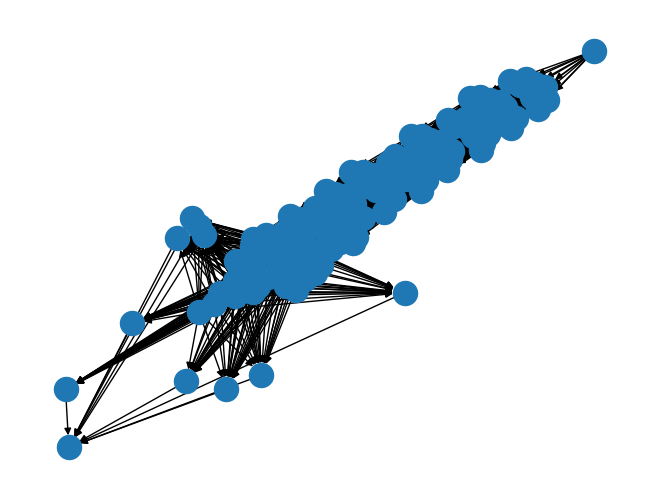

In [121]:
nx.draw(G, with_labels=False)

In [122]:
max_flow_value, flow_dict = nx.maximum_flow(G, source_node, sink_node)

In [123]:
flow_dict

{13: {(0, 0): 17.721712708473206,
  (0, 1): 17.436167120933533,
  (0, 2): 17.225807905197144,
  (0, 3): 17.46664184331894,
  (0, 4): 17.442363500595093,
  (0, 5): 17.45434957742691,
  (0, 6): 16.632327377796173,
  (0, 7): 17.47032856941223,
  (0, 8): 17.400444209575653,
  (0, 9): 17.191332757472992},
 (0, 0): {(1, 0): 0.8600838780403137,
  (1, 1): 0.8691505789756775,
  (1, 2): 0.869370698928833,
  (1, 3): 0.8683768510818481,
  (1, 4): 0.8715229034423828,
  (1, 5): 0.9349750280380249,
  (1, 6): 0.9460166096687317,
  (1, 7): 0.9177135825157166,
  (1, 8): 0.8737959861755371,
  (1, 9): 0.8607720136642456,
  (2, 0): 0.8838162422180176,
  (2, 1): 0.846067488193512,
  (2, 2): 0.8927154541015625,
  (2, 3): 0.8557533025741577,
  (2, 4): 0.8645268082618713,
  (2, 5): 0.902775228023529,
  (2, 6): 0.951092004776001,
  (2, 7): 0.9177135825157166,
  (2, 8): 0.8747024536132812,
  (2, 9): 0.8607720136642456},
 (1, 0): {(2, 0): 0.6451883912086487,
  (2, 1): 0.61915123462677,
  (2, 2): 0.671390831470489

In [124]:
node_scores = {k: sum([score for _, score in flow_dict[k].items()]) for k in flow_dict if k not in [source_node, sink_node]}

In [125]:
for i, j in sorted(node_scores, key=node_scores.get, reverse=True):
  print(section_keywords[i][j][0])

('pca', 0.3965)
('factor analysis', 0.392)
('telepresence', 0.4074)
('large numbers', 0.4282)
('similar research', 0.4278)
('warburton', 0.3949)
('performative learning', 0.445)
('high levels', 0.38)
('new understanding', 0.3749)
('impacting learners', 0.4142)
('foster socialization', 0.4512)
('forties', 0.4406)
('additional evidence', 0.3813)
('virtual learning', 0.3774)
('deshpande', 0.4723)
('intrinsic motivation', 0.3839)
('online learning', 0.3836)
('exploratory behavior', 0.5357)
('smyslova', 0.4023)
('extrinsic reason', 0.5036)
('group affiliations', 0.4436)
('positive emotions', 0.4082)
('real time', 0.3976)
('recent trends', 0.3941)
('second factor', 0.3654)
('energized focus', 0.5461)
('internet use', 0.454)
('cognitive sense', 0.3879)
('realness', 0.3895)
('brandworlds', 0.4246)
('anonymity', 0.4393)
('official language', 0.4395)
('factor analysis', 0.4299)
('main reason', 0.4391)
('computer games', 0.4002)
('experiential learning', 0.5658)
('increased learning', 0.3887)
('v